# Radiomics to diagnose single brain tumors: GBM vs. Metastasis vs. Lymphoma

### *JBO, Chansik An, and Sung Soo Ahn*

## 1) Data cleaning



In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# load and dissect the dataset, and do some sanity checks
df = pd.read_csv('Data/main_data(JBO).csv', index_col='id')

df_Peri_T1 = df.filter(like='mask1_T1', axis=1)
df_Peri_T2 = df.filter(like='mask1_T2', axis=1)
df_CE_T1 = df.filter(like='mask2_T1', axis=1)
df_CE_T2 = df.filter(like='mask2_T2', axis=1)
y = df['mask2_target']
print('Shapes of CE_T1, CE_T2, PeriT2_T1, PeriT2_T2, and y: \n',
      df_CE_T1.shape, df_CE_T2.shape, df_Peri_T1.shape, df_Peri_T2.shape, 
      y.shape, '\n')

print('Check if all the feature names are consistent:', 
  sorted([col_name.split('_', 2)[2] for col_name in df_CE_T1.columns]) == \
  sorted([col_name.split('_', 2)[2] for col_name in df_CE_T2.columns]) == \
  sorted([col_name.split('_', 2)[2] for col_name in df_Peri_T1.columns]) == \
  sorted([col_name.split('_', 2)[2] for col_name in df_Peri_T2.columns]), '\n'
)

# check redundant 'shape' features from T2 images
df_Peri_T2_shape = df_Peri_T2.filter(like='mask1_T2_shape')
df_CE_T2_shape = df_CE_T2.filter(like='mask2_T2_shape')

print('{0} shape features are redundant for CE and Peri T2 masks.'.
      format(df_CE_T2_shape.shape[1] + df_Peri_T2_shape.shape[1]))
print('Names of redundant shape features, from T2 images: \n',
      df_CE_T2_shape.columns.values, df_Peri_T2_shape.columns.values, '\n')

# datasets after excluding redudant shape features
df_CE_no_redundancy = pd.concat(
    [df_CE_T1, df_CE_T2.drop(df_CE_T2_shape.columns, axis=1)], axis=1)
df_Peri_no_redundancy = pd.concat(
    [df_Peri_T1, df_Peri_T2.drop(df_Peri_T2_shape.columns, axis=1)], axis=1)
print('Shapes of CE mask and PeriT2 mask datasets without redundancy:',
      df_CE_no_redundancy.shape, df_Peri_no_redundancy.shape, '\n')

# finalize the dataset
X = pd.concat([df_CE_no_redundancy, df_Peri_no_redundancy], axis=1)
print('Check if the indices of X and y are consistent in order:',
      np.mean(X.index == y.index) == 1)

X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

final_df = pd.concat([X, y], axis=1)

Shapes of CE_T1, CE_T2, PeriT2_T1, PeriT2_T2, and y: 
 (538, 93) (538, 93) (538, 93) (538, 93) (538,) 

Check if all the feature names are consistent: True 

28 shape features are redundant for CE and Peri T2 masks.
Names of redundant shape features, from T2 images: 
 ['mask2_T2_shape_Elongation' 'mask2_T2_shape_Flatness'
 'mask2_T2_shape_LeastAxisLength' 'mask2_T2_shape_MajorAxisLength'
 'mask2_T2_shape_Maximum2DDiameterColumn'
 'mask2_T2_shape_Maximum2DDiameterRow'
 'mask2_T2_shape_Maximum2DDiameterSlice'
 'mask2_T2_shape_Maximum3DDiameter' 'mask2_T2_shape_MeshVolume'
 'mask2_T2_shape_MinorAxisLength' 'mask2_T2_shape_Sphericity'
 'mask2_T2_shape_SurfaceArea' 'mask2_T2_shape_SurfaceVolumeRatio'
 'mask2_T2_shape_VoxelVolume'] ['mask1_T2_shape_Elongation' 'mask1_T2_shape_Flatness'
 'mask1_T2_shape_LeastAxisLength' 'mask1_T2_shape_MajorAxisLength'
 'mask1_T2_shape_Maximum2DDiameterColumn'
 'mask1_T2_shape_Maximum2DDiameterRow'
 'mask1_T2_shape_Maximum2DDiameterSlice'
 'mask1_T2_shape_Max

In [3]:
# Stratified train-test splitting
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print('Shapes of X_train, X_test, y_train, y_test: \n',
      X_train.shape, X_test.shape, y_train.shape, y_test.shape, '\n')

df_train = pd.concat([X_train, y_train], axis=1)
df_train.columns
df_test = pd.concat([X_test, y_test], axis=1)

print('No. of cases according to the diagnosis \n\n',
      'In the training set: \n',
      df_train.groupby(['mask2_target']).size(), '\n\n',
      'In the test set: \n', 
      df_test.groupby(['mask2_target']).size(), '\n')

Shapes of X_train, X_test, y_train, y_test: 
 (376, 344) (162, 344) (376,) (162,) 

No. of cases according to the diagnosis 

 In the training set: 
 mask2_target
GBM         210
lymphoma     51
meta        115
dtype: int64 

 In the test set: 
 mask2_target
GBM         90
lymphoma    22
meta        50
dtype: int64 



## Feature

In [47]:
#!pip install -U scikit-learn 
import numpy as np
from datetime import datetime
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

clf = AdaBoostClassifier(random_state=42)
sfs_results = dict()

for n_feat in range(1, 51):
    stime = datetime.now()
    print('Now working on selecting {0} features'.format(n_feat))
    
    sfs = SequentialFeatureSelector(clf, 
        n_features_to_select=n_feat, direction='forward', 
        scoring='balanced_accuracy', cv=5, n_jobs=-1)
    sfs.fit(X_train, y_train)
    
    X_train_selected = sfs.transform(X_train)
    selected_feat_names = list(X_train.columns[sfs.support_])
    
    cv_scores = cross_val_score(clf, X_train_selected, y_train, cv=5) 
    m, sd = np.mean(cv_scores), np.std(cv_scores)
    print('...CV score: mean,', round(m, 3), ' /', 'std,', round(sd, 3))
    
    sfs_results[n_feat] = [m, sd, selected_feat_names]
    
    ftime = datetime.now()
    print('...Elapsed time:', ftime - stime)

Working to select 2 features
CV score: mean, 0.652  / std, 0.033
Elapsed time: 0:04:32.957382
Working to select 3 features
CV score: mean, 0.654  / std, 0.021
Elapsed time: 0:07:03.720718
Working to select 4 features
CV score: mean, 0.652  / std, 0.025
Elapsed time: 0:09:42.902599
Working to select 5 features
CV score: mean, 0.654  / std, 0.027
Elapsed time: 0:11:37.690389


In [48]:
# create dataframe for plotting
df_plot = pd.DataFrame()

for key, values in sfs_results.items():
    row = pd.DataFrame({'No_of_features': key, 
                        'Mean_score': values[0],
                        'SD_score': values[1]}, index=[0])
    df_plot = pd.concat([df_plot, row], axis=0)

df_plot.to_csv('Data/ADA_sfs_results.csv')


<ErrorbarContainer object of 3 artists>

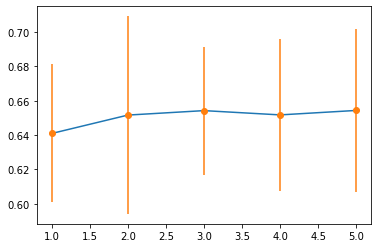

In [52]:
import numpy as np
import matplotlib.pyplot as plt

n_feat = df_plot['No_of_features']
m = df_plot['Mean_score']
err = df_plot['SD_score'] * 1.96 / np.sqrt(len(df_plot)) * 2

plt.plot(n_feat, m)
plt.errorbar(n_feat, m, yerr=err, fmt='o')


In [61]:
sfs.scoring

## 2) Exploratory data analysis

In [46]:
from pandas_profiling import ProfileReport

In [41]:
selectedFeat1 = list(pd.read_csv('Data/selFeat1.csv')['Feature'])
lst = selectedFeat1 + ['mask2_target']
df_selected = df_train.filter(lst) 

In [ ]:
profile = ProfileReport(df_selected, title = "First profiling report")
profile.to_file(output_file='Data/profiling_result1.html')

### Feature selection

In [47]:
fs_MI = pd.read_csv('feature_select_result_MI.csv', index_col=[0])
fs_RF = pd.read_csv('feature_select_result_RF.csv', index_col=[0])
fs_Fscore = pd.read_csv('feature_select_result_Fscore.csv', index_col=[0])

result_dict = {'MI': fs_MI['mean'], 'RF': }
fs_RF.head()
fs_Fscore.head()

,mean,std
mask2_T2_shape_Sphericity,39.774354,10.029649
mask2_T1C_firstorder_Skewness,36.817725,8.882845
mask2_T2_shape_SurfaceArea,29.611904,7.259968
mask2_T1C_glszm_GrayLevelNonUniformity,28.186906,6.709893
mask2_T1C_ngtdm_Busyness,26.878637,6.567453


In [65]:
fs_combined = fs_MI.join(fs_RF, lsuffix='M', rsuffix='R').join(fs_Fscore)
fs_combined.columns = ['MI_mean', 'MI_std', 'RF_mean', 'RF_std', 'F_mean', 'F_std']
fs_combined.to_csv('Data/VIM_combined.csv', index=True)